In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import minimize
from ipywidgets import interactive
from scipy.stats import rayleigh
import pandas as pd

## 1. Helper Functions

In [8]:
# GENERATING SIGNALS
def generate_signal(num_samples_signal, num_bins, m_min, m_max, s_mean, s_stddev, num_histograms):
    """
    INPUT:
        num_samples = total number of signal events in the data
        num_bins    = number of bins (denoted by "N" in the text)
        m_min, m_max= sets the range for the mass
        s_mean      = mean of the signal (position)
        s_stddev    = standard deviation of the signal (scale)
        num_histograms= number of histograms on which we will average on
    OUTPUT:
        signal_average_hist = average count of Signal events going to each bin (s = [s_1, s_2,...,s_N])
        signal_average      = mean over random samples (of size num_samples) drawn from N(mu, sigma)
        signal_hist_list    = contains the counts of events in each bin for all histograms generated

    """

    bin_edges = np.linspace(m_min, m_max, num_bins+1)
    bins = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]

    signal_hist_list = []
    signals_list = []
    # signal_vals_list = []

    for _ in range(num_histograms):
        # generate random samples for each event
        signal_sample = np.random.normal(s_mean, s_stddev, size=num_samples_signal)

        # generate SIGNAL historgram from the given sample 
        signal_hist, _  = np.histogram(signal_sample, bins=bin_edges)

        # append it to hist_list
        signal_hist_list.append(signal_hist)
        signals_list.append(signal_sample)
        # signal_vals_list.append(signal_vals)

    signal_average_hist   = np.mean(signal_hist_list, axis=0)
    signal_average = np.mean(signals_list, axis=0)
    # signal_average_val = np.mean(signal_vals_list, axis=0)

    return signal_average_hist, signal_average, signal_hist_list

In [9]:
def get_f_b(bin_edges, rayleigh_scale_parameter):
    """
    INPUT:
        bin_edges = pre-defined bins' edges
        rayleigh_scale_parameter = parameter for the distribution of the Background
    OUTPUT:
        bin_probabilities = probability for Background event to fall into each bin (f_b = [f_b1,f_b2,...,f_bN])
    """
    my_bins = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges) - 1)]
    bin_probabilities = []
    for bin_edge in my_bins:
        bin_probability = rayleigh.cdf(bin_edge[1], scale=rayleigh_scale_parameter) - rayleigh.cdf(bin_edge[0], scale=rayleigh_scale_parameter)
        bin_probabilities.append(bin_probability)
    return bin_probabilities

In [10]:
def get_n(signal_average_hist, f_b, mu, theta):
    """
    INPUT:
        signal_average_hist = average count of Signal events going to each bin                  (s_i)
        f_b                 = probability for Background event to fall into each bin            (f_{b,i})
        mu                  = strength of the Signal                                            (mu)
        theta               = Total number of Background events                                 (theta)
    OUTPUT:
        n_samples           = total number of events going into each bin                        (n = [n_1,n_2,...,n_N])
    """
    s = [int(i) for i in signal_average_hist]
    E_n = [mu*s_i + theta*f_b_i for (s_i,f_b_i) in zip(s,f_b)]
    num_samples = 1
    n_samples = [np.random.poisson(n_mean, num_samples) for n_mean in E_n]
    return n_samples

In [11]:
def logLikelihood(s, f_b, n, mu, theta):
    """
    INPUT:
        s       =   average count of Signal events going to each bin                  (s_i)
        f_b     =   probability for Background event to fall into each bin            (f_{b,i})
        n       =   total number of events going into each bin                        (n = [n_1,n_2,...,n_N])
        mu      =   strength of the Signal                                            (mu)
        theta   =   Total number of Background events                                 (theta)
    OUTPUT: 
        sum     =   log-likelihood given mu and theta                                 (log(L(mu, theta)))
    """
    s = s
    b = [theta * f_b_i for f_b_i in f_b]
    term1, term2, term3 = 0, 0, 0
    for i in range(len(s)):
        s_i   = s[i]
        f_b_i = f_b[i]
        n_i   = n[i]
        b_i   = b[i]
        # b_i   = mu*s_i + theta*f_b_i
        # print(f"n_i: {n[i]}, s_i: {s[i]}, b_i: {b[i]}")
        E_n = mu*s_i + b_i
        if (E_n<=0):
            print(f"E_n = {E_n} for s_i = {s_i}, f_b_i={b_i}, n_i={n_i}, theta = {theta}")
        # print(f"E_n: {E_n}")
        term1 += n_i*math.log(E_n)
        term2 += math.log(math.factorial(n_i))
        term3 += E_n
        # print(f"i:\t{i}, term1: \t{term1}, term2: \t{term2}, term3: \t{term3}, E_n: {E_n}, n_i: {n_i}, s: {s_i}, b {b_i}")
    sum = term1 - term2 - term3
    # print(f"mu: {mu}, theta: {theta}, sum: {sum}")
    return sum  

In [12]:
def maximize_wrt_theta(init_guess, mu_hypothesis, s, f_b, n) :
    """
    DESCR:  Maximizes the Log-likelihood function with respect to theta (holding mu constant) --> This is the numerator part of the Maximum Likelihood Ratio

    INPUT: 
        init_guess      =   guess value of theta for the optimizer
        mu_hypothesis   =   strength of the signal that we are assuming as hypothesis (mu_hypothesis != mu_data)
        s               =   average count of Signal events going to each bin                  (s_i)
        f_b             =   probability for Background event to fall into each bin            (f_{b,i})
        n               =   total number of events going into each bin                        (n = [n_1,n_2,...,n_N])
    
    OUTPUT:
        optimal_theta_num   =   Value of theta that maximizes the Log-likelihood function
        optimal_function    =   Maximum value of the objective function

    """
    initial_guess = [init_guess]
    mu = mu_hypothesis

    # method
    method = 'SLSQP'

    bounds = [(1, 15000)]  

    # minimize the logLikelihood function with respect to theta using your chosen method
    result_num = minimize(lambda x: -logLikelihood(s, f_b, n, mu, x[0]), initial_guess, method=method, bounds=bounds)

    # \hat{\hat{\mu}}
    optimal_theta_num = result_num.x[0]
    optimal_function = -result_num.fun

    # # result
    # print(f"Optimal theta: {optimal_theta_num}")
    # print(f"Optimal Function: {-result_num.fun}")
    return optimal_theta_num, optimal_function

In [13]:
def maximize_wrt_mu_theta(init_guess_theta, init_guess_mu, s, f_b, n):
    """
    DESCR:  Maximizes the Log-likelihood function with respect to theta and mu --> This is the denominator part of the Maximum Likelihood Ratio

    INPUT: 
        init_guess_theta=   guess value of theta for the optimizer
        init_guess_mu   =   guess value of mu for the optimizer
        s               =   average count of Signal events going to each bin                  (s_i)
        f_b             =   probability for Background event to fall into each bin            (f_{b,i})
        n               =   total number of events going into each bin                        (n = [n_1,n_2,...,n_N])
    
    OUTPUT:
        optimal_mu_den      =   Value of mu that maximizes the Log-likelihood function
        optimal_theta_den   =   Value of theta that maximizes the Log-likelihood function
        optimal_function    =   Maximum value of the objective function
    """
    # initial theta and mu: assumed = [10000, 0.3]
    initial_guess = [init_guess_theta, init_guess_mu]  

    # bounds for theta and mu 
    bounds = [(1, 15000), (0, 1)]  

    # method
    method = 'SLSQP'

    # minimizing the -logLikelihood function 
    result_den = minimize(lambda x: -logLikelihood(s, f_b, n, x[1], x[0]), initial_guess, bounds=bounds, method=method)

    # \hat{theta}, \hat{mu}
    optimal_theta_den, optimal_mu_den = result_den.x[0], result_den.x[1]
    optimal_function = -result_den.fun

    # # Phe results
    # print(f"Optimal theta: {optimal_theta_den}")
    # print(f"Optimal mu: {optimal_mu_den}")
    # print(f"ll: {-result_den.fun}")
    return optimal_mu_den, optimal_theta_den, optimal_function

In [143]:
# LOG_LIKELIHOOD RATIO
def log_likelihood_ratio(init_mu, init_theta, signal, f_b, n, mu_hypothesis, print_vals=False, mu_assumed=None, theta_assumed=None):
    """
    DESCR:  Calculates the log-likelihood ratio 

    INPUT:
        init_theta      =   guess value of theta for the optimizer
        init_mu         =   guess value of mu for the optimizer
        signal          =   average count of Signal events going to each bin                  (s_i)
        f_b             =   probability for Background event to fall into each bin            (f_{b,i})
        n               =   total number of events going into each bin                        (n = [n_1,n_2,...,n_N])
        mu_hypothesis   =   strength of the signal that we are assuming as hypothesis (mu_hypothesis != mu_data)
        print_vals      =   prints additional information if True
        mu_assumed      =   signal strength in the underlying data (used only for printing and not for calculation!)
        theta_assumed   =   total number of background events in the underlying data (used only for printing and not for calculation!)
    
    OUTPUT:
        theta_hat_hat   =   maximizer of the log-likelihood when mu=mu_hypothesis  (maximizer of the numerator term of likelihood ratio)
        mu_hat          =   maximizer of the log-likelihood wrt mu (maximizer of the denominator term of likelihood ratio wrt mu)
        theta_hat       =   maximizer of the log-likelihood wrt theta (maximizer of the denominator term of likelihood ratio wrt theta)
        optim_num       =   maximum numerator term of the likelihood ratio
        optim_den       =   maximum denominator term of the likelihood ration
        ll_ratio        =   log-likelihood ratio
    """
    theta_hat_hat, optim_num = maximize_wrt_theta(init_theta, mu_hypothesis, signal, f_b, n)               # numerator
    mu_hat, theta_hat, optim_den = maximize_wrt_mu_theta(init_theta, init_mu, signal, f_b, n)              # denominator
    ll_ratio = optim_num - optim_den
    if print_vals==True:
        print(f"theta assumed: {theta_assumed}")
        print(f"mu assumed: {mu_assumed}")
        print(f"mu hypothesised: {mu_hypothesis}\n")
        print(f"---- NUMERATOR VALUES ----")
        print(f"theta_double_hat: {theta_hat_hat}")
        print(f"optimum likelihood (numerator): {optim_num}\n")
        print(f"---- DENOMINATOR VALUES ----")
        print(f"mu hat: {mu_hat}")
        print(f"theta hat: {theta_hat}")
        print(f"optimum likelihood (denominator): {optim_den}\n")
        print(f"Log-Likelihood Ratio: {ll_ratio}")
    return theta_hat_hat, mu_hat, theta_hat, optim_num, optim_den, ll_ratio

In [144]:
# TEST SATISTIC FOR UPPER LIMIT
def get_q_mu(init_mu, init_theta, s, f_b, n, mu_hypothesis, print_info=None):
    theta_hat_hat, mu_hat, theta_hat, optim_num, optim_den, ll_ratio = log_likelihood_ratio(init_mu=init_mu, 
                                                                                            init_theta=init_theta, 
                                                                                            signal=s, 
                                                                                            f_b=f_b, 
                                                                                            n=n, 
                                                                                            mu_hypothesis=mu_hypothesis,
                                                                                            print_vals=False)
    if (mu_hat <= mu_hypothesis):
        test_statistic = -2*ll_ratio
    else:
        test_statistic = 0
        
    if print_info==True:
        print(f"mu_hat: {mu_hat}")
        print(f"mu_hypothesised: {mu_hypothesis}")
        print(f"ll_ratio: {ll_ratio}")
        print(f"q_hat: {test_statistic}")

    return test_statistic

In [218]:
"""
It is assumed that the MLE mu_hat ~ N(mu_data, sigma)
"""
def get_q_mu_asymptotic(mu_hypothesis, mu_hat, sigma):
        if mu_hat <= mu_hypothesis:
            num = (mu_hypothesis - mu_hat)**2
            den = sigma**2
            return num / den
        else:
            return 0

def f_q_mu(mu_hypothesis, mu_data, mu_hat, sigma, q_mu_asymptotic = None):
        # q_mu_asymptotic = get_q_mu_asymptotic(mu_hypothesis=mu_hypothesis,
        #                                     mu_hat=mu_hat,
        #                                     sigma=sigma)
        
        term1 = norm.cdf((mu_data - mu_hypothesis) / (sigma)) * (q_mu_asymptotic==0)
        term2_part1 = 0.5 * (1 / np.sqrt(2 * np.pi)) * (1 / np.sqrt(q_mu_asymptotic)) 
        term2_part2 = np.exp(-0.5 * (np.sqrt(q_mu_asymptotic) - (mu_hypothesis - mu_data)/sigma)**2)

        return term1 + term2_part1*term2_part2

In [247]:
# CALCULATE THE ASYMPTOTIC DISTRIBUTION VALUES
def asymptotic_dist(init_mu, init_theta, asimov_data, s, f_b, mu_hypothesis, q_mu_vals, mu_data):
    n_asymptotic = [np.random.choice(asimov_n_i) for asimov_n_i in asimov_data]
    _, mu_hat, _, _, _, _ = log_likelihood_ratio(init_mu=init_mu, 
                                                init_theta=init_theta, 
                                                signal=s, 
                                                f_b=f_b, 
                                                n=n_asymptotic, 
                                                mu_hypothesis=mu_hypothesis,
                                                print_vals=False)

    max_q_mu = np.max(q_mu_vals)
    min_q_mu = np.min(q_mu_vals)
    q_mu_vals_range = np.arange(min_q_mu, max_q_mu, 0.1)

    # calculate the distribution
    max_q_mu = np.max(q_mu_vals)
    min_q_mu = np.min(q_mu_vals)
    q_mu_vals_range = np.arange(min_q_mu, max_q_mu, 0.1)
    asymptotic_dist_vals = [f_q_mu(mu_hypothesis=mu_hypothesis, 
                                mu_data=mu_data, 
                                mu_hat=mu_hat, 
                                sigma=0.1,
                                q_mu_asymptotic=q) for q in q_mu_vals_range]
    return q_mu_vals_range, asymptotic_dist_vals


## 2. Calculating the Statistic Using Monte-Carlo for a Particular Value $\mu = 0.6$ (hypothesis)  and $\mu' = 0.5$ (data)

In [240]:
# COMMON PARAMETERS
num_bins = 100
num_histograms = 100
m_min, m_max = 0, 120
bin_edges = np.linspace(m_min, m_max, num_bins+1)

# SIGNAL PARAMETERS
num_samples_signal = 1000
s_mean = 45
s_stddev = 2
signal_average_hist, _, _ = generate_signal(num_samples_signal, num_bins, m_min, m_max, s_mean, s_stddev, num_histograms)

# CALCULATE THE MEAN SIGNAL EVENTS
s = [int(i) for i in signal_average_hist]

# BACKGROUND PARAMETERS
rayleigh_scale_parameter = 20
num_samples_background = 10000
theta = num_samples_background

# CALCULATE THE BACKGROUND PROBABILITIES FOR EACH BIN
f_b = get_f_b(bin_edges, rayleigh_scale_parameter)

# CHOOSE THE SIGNAL STRENGTH
mu_data= 0.5

# CALCULATE THE EXPECTED NUMBER OF EVENTS IN EACH BIN
E_n = [mu_data*s_i + theta*f_b_i for (s_i,f_b_i) in zip(s,f_b)]
asimov_n = [np.random.poisson(E_n_i, size=100000) for E_n_i in E_n] 

# DATA WITH ZERO SIGNAL STRENGTH
E_n_0 = [0*s_i + theta*f_b_i for (s_i,f_b_i) in zip(s,f_b)]
asimov_n_0 = [np.random.poisson(E_n_i, size=100000) for E_n_i in E_n_0] 

# # PLOTTING 1000 SAMPLES
# plt.plot(asimov_n)
# plt.show()

In [241]:
num_iterations = 1000
q_mu_vals = []
q_mu_0_vals = []
for _ in range(num_iterations):

    # Sample from E_n
    np.random.seed(None)
    n = [np.random.choice(asimov_n_i) for asimov_n_i in asimov_n]
    n_0 = [np.random.choice(asimov_n_i) for asimov_n_i in asimov_n_0]

    # Calculate the Likelihood (L)
    # log_likelihood_mu_theta = logLikelihood(s, f_b, n, mu, theta)

    # Calculate the likelihood-ratio (\lambda)
    init_mu = 0.1
    init_theta = 5000
    mu_hypothesis = 0.5 # this is the mu that we are testing for 
    # theta_hat_hat, mu_hat, theta_hat, optim_num, optim_den, ll_ratio = log_likelihood_ratio(init_mu, init_theta, s, f_b, n, mu_hypothesis, print_vals=False, mu_assumed=None, theta_assumed=None)
    # theta_hat_hat_0, mu_hat_0, theta_hat_0, optim_num_0, optim_den_0, ll_ratio_0 = log_likelihood_ratio(init_mu, init_theta, s, f_b, n_0, mu_hypothesis, print_vals=False, mu_assumed=None, theta_assumed=None)

    # Calculate the q_mu statistics
    q_mu = get_q_mu(init_mu, init_theta, s, f_b, n, mu_hypothesis, print_info=None)
    q_mu_0 = get_q_mu(init_mu, init_theta, s, f_b, n_0, mu_hypothesis, print_info=None)

    q_mu_vals.append(q_mu)
    q_mu_0_vals.append(q_mu_0)

In [252]:
# ASYMPTOTIC DISTRIBUTION
q_mu_vals_range, asymptotic_dist_vals = asymptotic_dist(init_mu, 
                                    init_theta, 
                                    asimov_data=asimov_n, 
                                    s=s, 
                                    f_b=f_b, 
                                    mu_hypothesis=mu_hypothesis, 
                                    q_mu_vals=q_mu_vals, 
                                    mu_data=mu_data)

q_mu_vals_range_0, asymptotic_dist_vals_0 = asymptotic_dist(init_mu, 
                                    init_theta, 
                                    asimov_data=asimov_n_0, 
                                    s=s, 
                                    f_b=f_b, 
                                    mu_hypothesis=mu_hypothesis, 
                                    q_mu_vals=q_mu_0_vals, 
                                    mu_data=0)

/tmp/ipykernel_10394/3617260605.py:18: RuntimeWarning: invalid value encountered in sqrt
  term2_part1 = 0.5 * (1 / np.sqrt(2 * np.pi)) * (1 / np.sqrt(q_mu_asymptotic))
/tmp/ipykernel_10394/3617260605.py:19: RuntimeWarning: invalid value encountered in sqrt
  term2_part2 = np.exp(-0.5 * (np.sqrt(q_mu_asymptotic) - (mu_hypothesis - mu_data)/sigma)**2)


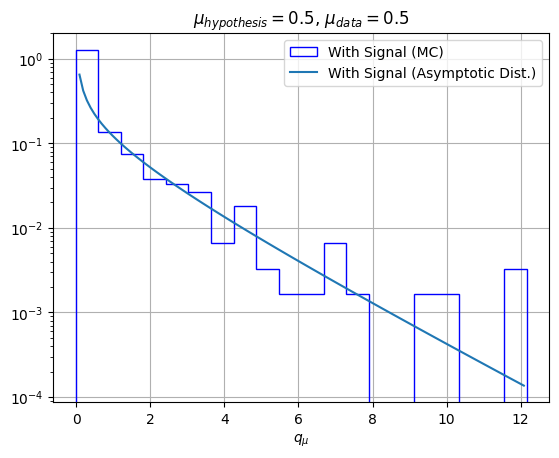

In [243]:
# SIMULATED
plt.hist(q_mu_vals, color='blue', histtype='step', bins=20, density=True, label="With Signal (MC)")
# plt.hist(q_mu_0_vals, color='red', histtype='step', bins=20, density=True, label="Without Signal")
plt.legend()
plt.title(f"$\mu_{{hypothesis}} = {mu_hypothesis}$, $\mu_{{data}} = {mu_data}$")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel("$q_{\mu}$")
plt.grid(True)


# ASYMPTOTIC
plt.plot(q_mu_vals_range, asymptotic_dist_vals, label='With Signal (Asymptotic Dist.)')

plt.legend()
plt.show()


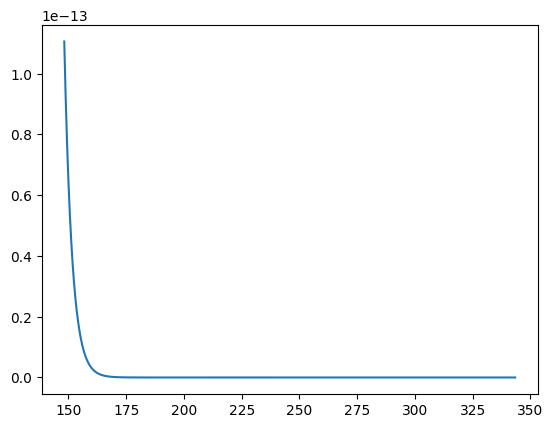

In [258]:
# plt.hist(q_mu_0_vals, color='red', histtype='step', bins=20, density=True, label="Without Signal")
plt.plot(q_mu_vals_range_0, asymptotic_dist_vals_0, label='Without Signal (Asymptotic Dist.)')
plt.show()

In [136]:
# COMMON PARAMETERS
num_bins = 100
num_histograms = 100
m_min, m_max = 0, 120
bin_edges = np.linspace(m_min, m_max, num_bins+1)

# SIGNAL PARAMETERS
num_samples_signal = 1000
s_mean = 45
s_stddev = 2
signal_average_hist, _, _ = generate_signal(num_samples_signal, num_bins, m_min, m_max, s_mean, s_stddev, num_histograms)

# CALCULATE THE MEAN SIGNAL EVENTS
s = [int(i) for i in signal_average_hist]

# BACKGROUND PARAMETERS
rayleigh_scale_parameter = 20
num_samples_background = 10000
theta = num_samples_background

# CALCULATE THE BACKGROUND PROBABILITIES FOR EACH BIN
f_b = get_f_b(bin_edges, rayleigh_scale_parameter)

def generate_q_mu(mu_data, mu_hypothesis):
    # CHOOSE THE SIGNAL STRENGTH FOR THE DATA
    mu_data = mu_data

    # CALCULATE THE EXPECTED NUMBER OF EVENTS IN EACH BIN
    E_n = [mu_data*s_i + theta*f_b_i for (s_i,f_b_i) in zip(s,f_b)]
    asimov_n = [np.random.poisson(E_n_i, size=100000) for E_n_i in E_n]      # data samples with Signal strength = mu_data

    # CALCULATE THE EXPECTED NUMBER OF EVENTS IN EACH BIN (For the case when there is no signal)
    E_n_0 = [0*s_i + theta*f_b_i for (s_i,f_b_i) in zip(s,f_b)]
    asimov_n_0 = [np.random.poisson(E_n_i, size=100000) for E_n_i in E_n_0]  # pure background data samples

    

    num_iterations = 100
    q_mu_list = []
    q_mu_prime_0_list = []

    for _ in range(num_iterations):

        # Sample from E_n
        n = [np.random.choice(asimov_n_i) for asimov_n_i in asimov_n]
        n_0 = [np.random.choice(asimov_n_i) for asimov_n_i in asimov_n_0]

        # Calculate the Likelihood (L)
        # log_likelihood_mu_theta = logLikelihood(s, f_b, n, mu, theta)

        # Calculate the likelihood-ratio (\lambda)
        init_mu = 0.1
        init_theta = 5000
        mu_hypothesis = mu_hypothesis # this is the mu that we are testing for 
        # theta_hat_hat, mu_hat, theta_hat, optim_num, optim_den, ll_ratio = log_likelihood_ratio(init_mu, init_theta, s, f_b, n, mu_hypothesis, print_vals=False, mu_assumed=None, theta_assumed=None)

        # Calculate the q_mu statistics
        q_mu = get_q_mu(init_mu, init_theta, s, f_b, n, mu_hypothesis, print_info=None)
        q_mu_prime_0 = get_q_mu(init_mu, init_theta, s, f_b, n_0, mu_hypothesis, print_info=None)

        q_mu_list.append(q_mu)
        q_mu_prime_0_list.append(q_mu_prime_0)
    
    return q_mu_list, q_mu_prime_0_list

In [110]:
np.sum(f_b)

0.9999999847700204

In [137]:
# mu_list = np.linspace(0,1,10)[1:]
mu_list = np.arange(0.1, 1.0, 0.1)

counter = 0
q_mu_list_dict = {}
q_mu_no_signal = {}
for mu in mu_list:
    try:
        # Case 1: mu = mu_prime (blue) AND Case 2: mu_prime = 0 (red)
        q_mu, q_mu_prime_0 = generate_q_mu(mu_data=mu, mu_hypothesis=mu)

        # Append the values
        q_mu_list_dict[mu] = q_mu
        q_mu_no_signal[mu] = q_mu_prime_0

        counter+=1
        print(f"#{counter} mu: {mu} Done!")

    except Exception as e:
        print(f"Error occurred for mu = {mu}: {e}")
        counter+=1
        continue

#1 mu: 0.1 Done!
#2 mu: 0.2 Done!
#3 mu: 0.30000000000000004 Done!
#4 mu: 0.4 Done!
#5 mu: 0.5 Done!
#6 mu: 0.6 Done!
#7 mu: 0.7000000000000001 Done!
#8 mu: 0.8 Done!
#9 mu: 0.9 Done!


In [95]:
# save both the dictionaries
np.save('q_mu_list_dict.npy', q_mu_list_dict)
np.save('q_mu_no_signal.npy', q_mu_no_signal)

# # load the dictionaries
# q_mu_list_dict = np.load('q_mu_list_dict.npy', allow_pickle=True).item()
# q_mu_no_signal = np.load('q_mu_no_signal.npy', allow_pickle=True).item()

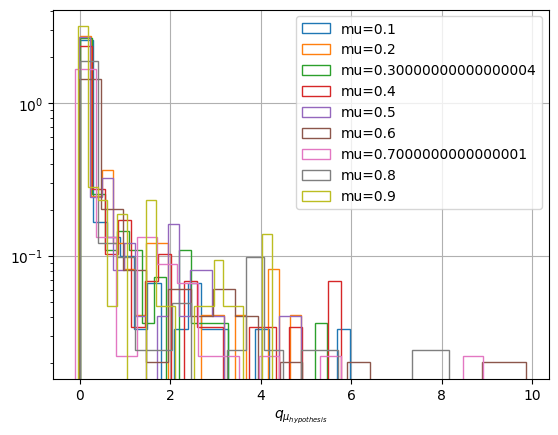

In [138]:
plt.hist(q_mu_list_dict[mu_list[0]], label=f'mu={mu_list[0]}', histtype='step', bins=20, density=True)
plt.hist(q_mu_list_dict[mu_list[1]], label=f'mu={mu_list[1]}', histtype='step', bins=20, density=True)
plt.hist(q_mu_list_dict[mu_list[2]], label=f'mu={mu_list[2]}', histtype='step', bins=20, density=True)
plt.hist(q_mu_list_dict[mu_list[3]], label=f'mu={mu_list[3]}', histtype='step', bins=20, density=True)
plt.hist(q_mu_list_dict[mu_list[4]], label=f'mu={mu_list[4]}', histtype='step', bins=20, density=True)
plt.hist(q_mu_list_dict[mu_list[5]], label=f'mu={mu_list[5]}', histtype='step', bins=20, density=True)
plt.hist(q_mu_list_dict[mu_list[6]], label=f'mu={mu_list[6]}', histtype='step', bins=20, density=True)
plt.hist(q_mu_list_dict[mu_list[7]], label=f'mu={mu_list[7]}', histtype='step', bins=20, density=True)
plt.hist(q_mu_list_dict[mu_list[8]], label=f'mu={mu_list[8]}', histtype='step', bins=20, density=True)

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel("$q_{\mu_{hypothesis}}$")
plt.grid(True)
plt.legend()
plt.show()

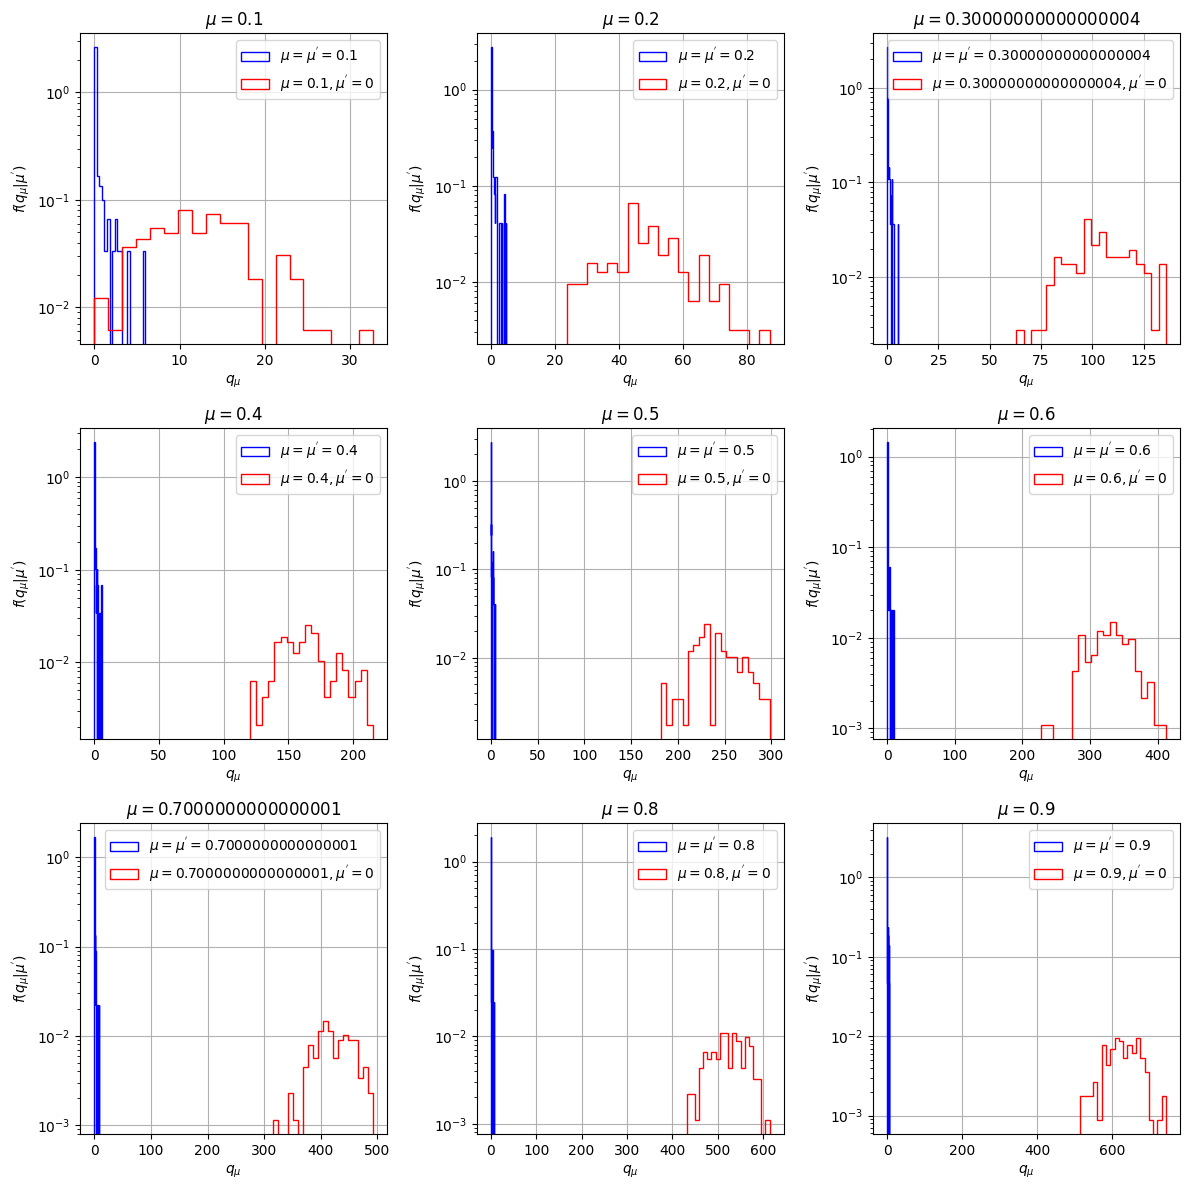

In [139]:
# Create subplots with a grid layout of 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Plot histograms for each mu value
for i, mu in enumerate(mu_list):
    row = i // 3
    col = i % 3
    axes[row, col].hist(q_mu_list_dict[mu], label=f"$\mu = \mu^{{'}}={mu}$", histtype='step', bins=20, density=True, color='blue')  # when mu = mu'
    axes[row, col].hist(q_mu_no_signal[mu], label=f"$\mu={mu}, \mu^{{'}}=0$", histtype='step', bins=20, density=True, color='red')  # when mu' = 0 (no signal in the data)
    axes[row, col].set_yscale('log')  
    axes[row, col].set_xlabel("$q_{\mu}$")
    axes[row, col].set_ylabel("$f(q_{{\mu}}|\mu^{{'}})$")
    axes[row, col].grid(True)
    axes[row, col].legend()
    axes[row, col].set_title(f"$\mu = {mu}$")

# Adjust layout
plt.tight_layout()
plt.show()